In [1]:
from itertools import chain
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

#fixes some bad rows and seperates data into train and test - note the seperation is not random, it should be.
#dependency collumns are split into rough lists for future
data = read_data()

def process_data(data):
    dataset = []
    feature_set = []
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)    
        deps = []
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            deps.append(organized_dependency)
        feature_set.append(deps)
        feature_set.append(sentence)
        dataset.append(feature_set)
        feature_set = []
    return dataset

p_data = pd.DataFrame(process_data(data))


In [2]:
p_data.columns = ['type', 'gerund', 'rel_deps', 'sentence']


In [3]:
p_data

,type,gerund,rel_deps,sentence
0,vp-ing,hearing,"[(xcomp, hearing, 5, remember, 4), (obj, phras...","I do n't remember hearing the phrase "" white g..."
1,vp-ing,Growing,"[(advcl, Growing, 1, had, 10), (compound:prt, ...","Growing up black in the 1950s , I never had th..."
2,vp-ing,having,"[(conj, irritability, 17, see, 3), (mark, at, ...","I can see now that possibly she was , but then..."
3,vp-ing,feeling,"[(xcomp, feeling, 4, remember, 3), (obj, sympa...",I can remember feeling a certain sympathy for ...
4,vp-ing,drawing,"[(advcl, victimizing, 16, feeling, 4), (mark, ...",I can remember feeling a certain sympathy for ...
...,...,...,...,...
55054,vp-ing,restraining,"[(mark, for, 5, restraining, 6), (acl, restrai...",The main government tools for restraining both...
55055,vp-ing,restraining,"[(mark, In, 1, restraining, 2), (advcl, restra...","In restraining such growth , allocation by pri..."
55056,vp-ing,learning,"[(obl, negotiations, 8, allow, 5), (punct, ,, ...","Therefore , change must allow for complex nego..."
55057,vp-ing,creating,"[(mark, of, 7, creating, 8), (advcl, creating,...","Political wisdom , therefore , consists of cre..."


In [4]:
def count(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep:
            sum += 1
    return sum

def countGerund(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep and (t[1].endswith('ing') or t[3].endswith('ing')):
            sum += 1
    return sum

def countCC(x):
    return count('cc', x)
def countConj(x):
    return count('conj', x)
def countPunct(x):
    return count('punct', x)

def countGerundCC(x):
    return countGerund('cc', x)
def countGerundConj(x):
    return countGerund('conj', x)
def countGerundPunct(x):
    return countGerund('punct', x)


In [5]:
p_data['num_cc'] = p_data['rel_deps'].apply(countCC)
p_data['num_conj'] = p_data['rel_deps'].apply(countConj)
p_data['num_punct'] = p_data['rel_deps'].apply(countPunct)
p_data['num_gerund_cc'] = p_data['rel_deps'].apply(countGerundCC)
p_data['num_gerund_conj'] = p_data['rel_deps'].apply(countGerundConj)
p_data['num_gerund_punct'] = p_data['rel_deps'].apply(countGerundPunct)


In [6]:
def count_dependencies(rel_deps):
    return len(rel_deps)

def contains_dependency(dep, rel_deps):
    for dependency in rel_deps:
        if dep in dependency:
            return 1
    return 0

def get_unique_deps(rels_deps):
    unique_deps = set()
    for data_point in rels_deps:
        for dep in data_point:
            unique_deps.add(dep[0])
    return list(unique_deps)


p_data['num_deps'] = p_data['rel_deps'].apply(count_dependencies)
dep_types = get_unique_deps(p_data['rel_deps'])
for dep_type in dep_types:
    p_data[f'contains_{dep_type}'] = p_data['rel_deps'].apply(lambda x: contains_dependency(dep_type, x))

p_data2 = p_data[['rel_deps']].copy()
    
for dep_type in dep_types:
    p_data2[f'contains_{dep_type}'] = p_data['rel_deps'].apply(lambda x: contains_dependency(dep_type, x))


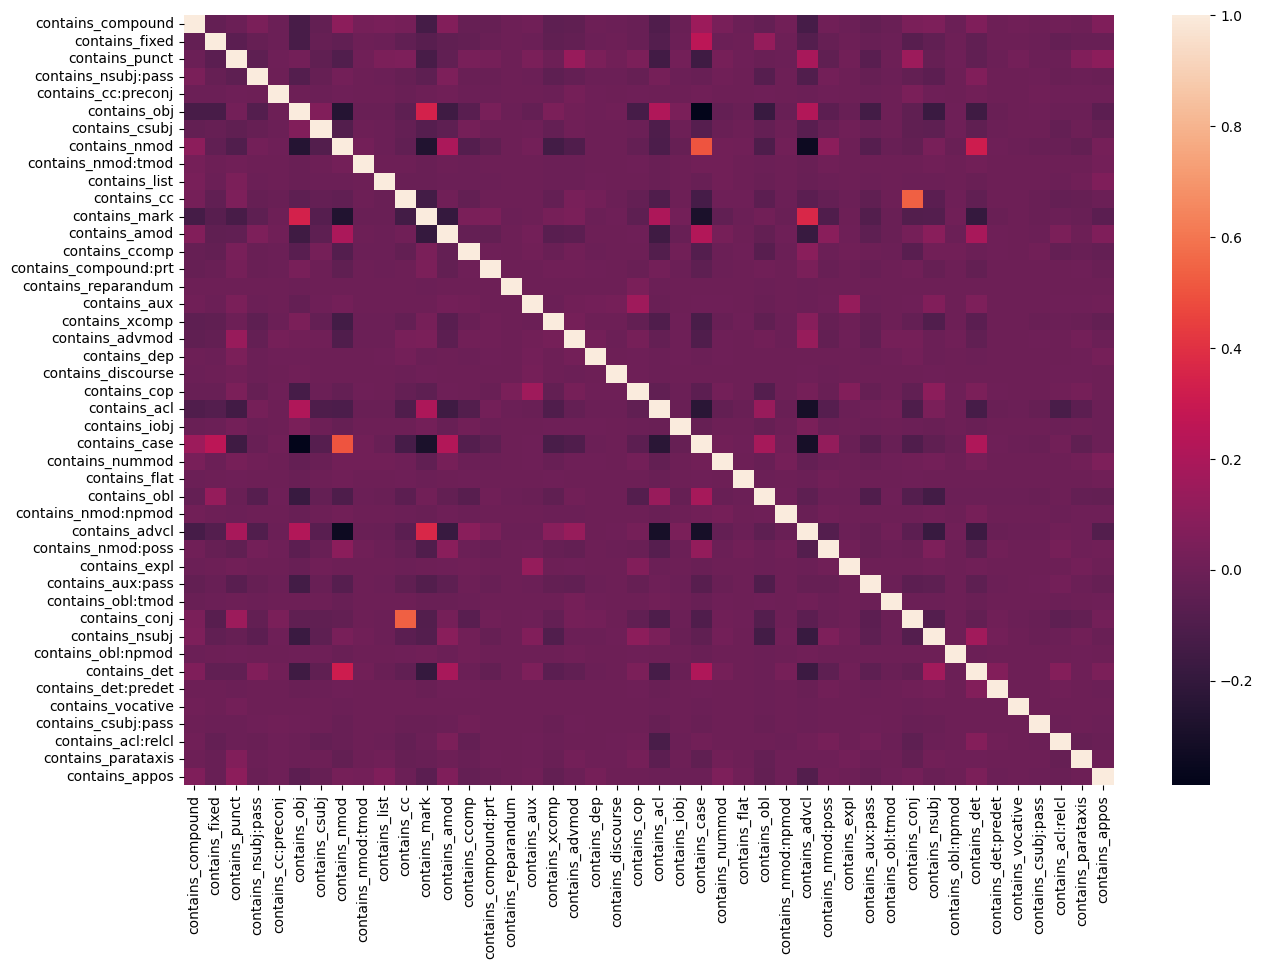

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(p_data2.corr(),  ax=ax)

plt.show()

C:\Users\varun\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


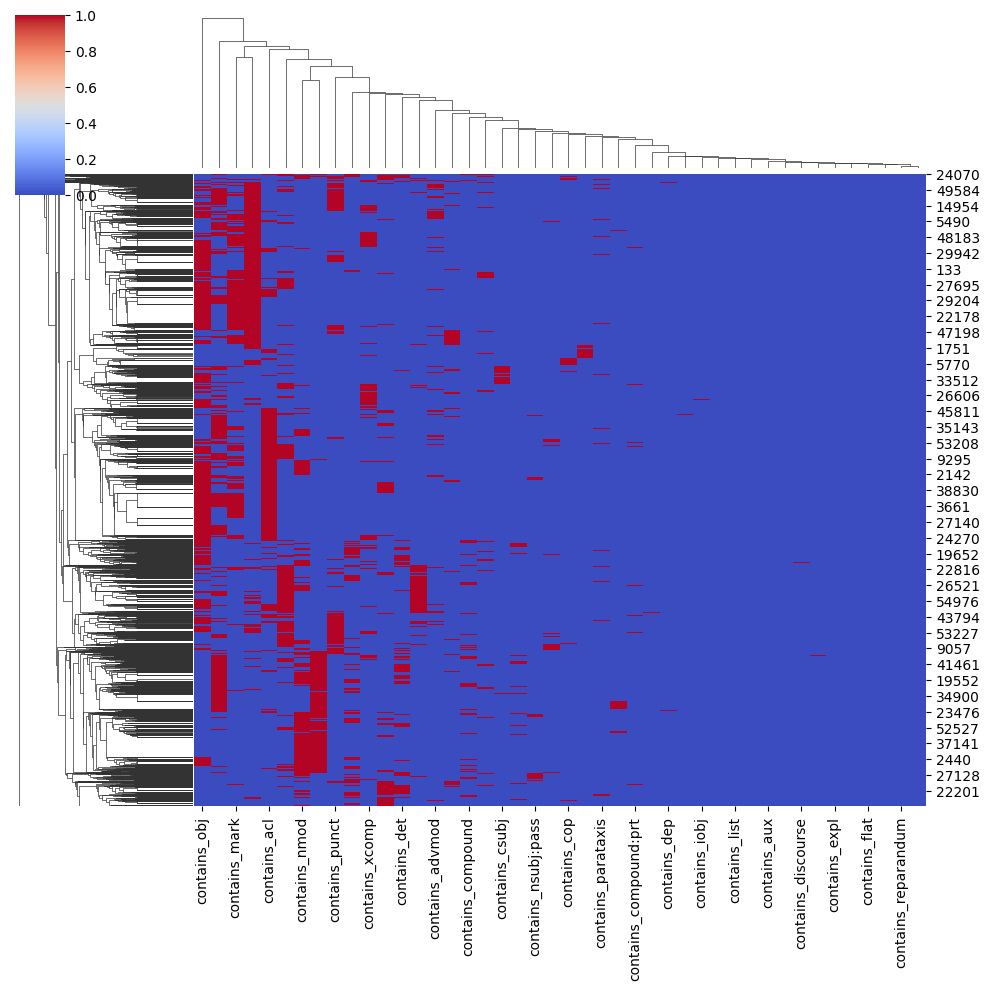

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

dep_cols = [f'contains_{dep_type}' for dep_type in dep_types]
p_data_deps = p_data2[dep_cols]

sns.clustermap(p_data_deps, cmap='coolwarm', figsize=(10,10))

plt.show()


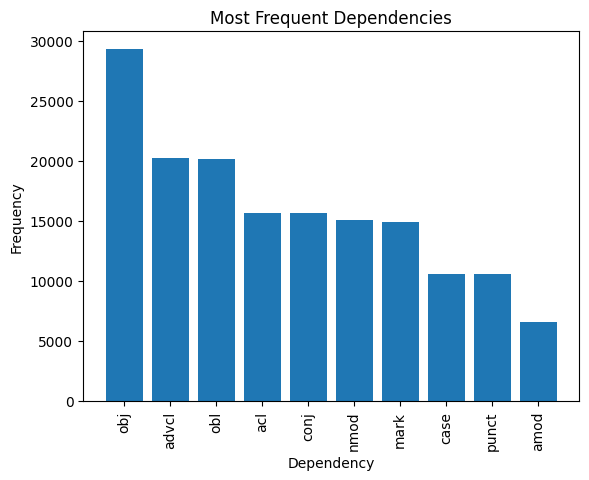

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

all_deps = []
for rels_deps in p_data['rel_deps']:
    for dep in rels_deps:
        all_deps.append(dep[0])

dep_counts = Counter(all_deps)

most_common_deps = dep_counts.most_common(10)

# Create a bar chart of the most frequent dependencies
labels, values = zip(*most_common_deps)
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.xlabel('Dependency')
plt.ylabel('Frequency')
plt.title('Most Frequent Dependencies')
plt.show()
